In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from statsforecast import StatsForecast

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
import lightgbm as lgb
import seaborn as sns



# Fourier terms (weekly)
def fourier_series(t, period, K):
    return pd.DataFrame({
        f'sin_{period}_{k}': np.sin(2 * np.pi * k * t / period)
        for k in range(1, K + 1)
    } | {
        f'cos_{period}_{k}': np.cos(2 * np.pi * k * t / period)
        for k in range(1, K + 1)
    })


In [5]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)

In [6]:
global_rows = []

for (store_nbr, family), df_sf in df.groupby(['store_nbr', 'family']):
    
    df_sf = df_sf.sort_values('date').set_index('date')
    y = df_sf['sales']

    # ----- target transforms -----
    y_log = np.log1p(y)
    
    t = np.arange(len(y_log)).reshape(-1, 1)
    trend_model = LinearRegression()
    trend_model.fit(t, y_log.values)
    trend = trend_model.predict(t)
    
    y_detrended = y_log - trend
    weekly_seasonality = y_detrended.groupby(y_detrended.index.dayofweek).transform('mean')
    y_transformed = y_detrended - weekly_seasonality
    y_transformed = y_transformed.dropna()

    X = pd.DataFrame(index=y_transformed.index)

    # lags
    for lag in [1, 7, 14]:
        X[f'lag_{lag}'] = y_transformed.shift(lag)

    # rolling stats
    X['roll_mean_7'] = y_transformed.rolling(7).mean()
    X['roll_std_7'] = y_transformed.rolling(7).std()
    X['ewm_7'] = y_transformed.ewm(span=7).mean()

    # calendar
    X['dow'] = X.index.dayofweek
    X['month'] = X.index.month
    X['time_idx'] = np.arange(len(X))

    # Fourier
    fourier = fourier_series(
        t=np.arange(len(X)),
        period=7,
        K=2
    )
    fourier.index = X.index
    X = pd.concat([X, fourier], axis=1)

    data = pd.concat([X, y_transformed.rename('y')], axis=1).dropna()

    data['store_nbr'] = store_nbr
    data['family'] = family
    data['unique_id'] = f'{store_nbr}_{family}'

    global_rows.append(data)

In [7]:
global_df = pd.concat(global_rows).reset_index()
global_df.rename(columns={'date': 'ds'}, inplace=True)

In [8]:
global_df

,ds,lag_1,lag_7,lag_14,roll_mean_7,roll_std_7,ewm_7,dow,month,time_idx,sin_7_1,sin_7_2,cos_7_1,cos_7_2,y,store_nbr,family,unique_id
0,2013-01-15,0.163622,0.050689,-1.045047,0.187252,0.329739,0.106430,1,1,14,-4.898587e-16,-9.797174e-16,1.000000,1.000000,-0.357652,1,AUTOMOTIVE,1_AUTOMOTIVE
1,2013-01-16,-0.357652,0.125226,0.128102,0.128918,0.375487,0.008057,2,1,15,7.818315e-01,9.749279e-01,0.623490,-0.222521,-0.283115,1,AUTOMOTIVE,1_AUTOMOTIVE
2,2013-01-17,-0.283115,0.223656,0.514214,0.070583,0.389764,-0.040493,3,1,16,9.749279e-01,-4.338837e-01,-0.222521,-0.900969,-0.184685,1,AUTOMOTIVE,1_AUTOMOTIVE
3,2013-01-18,-0.184685,0.367370,0.370246,-0.127869,0.538676,-0.287211,4,1,17,4.338837e-01,-7.818315e-01,-0.900969,0.623490,-1.021800,1,AUTOMOTIVE,1_AUTOMOTIVE
4,2013-01-19,-1.021800,0.054010,0.750033,-0.029259,0.632525,-0.028243,5,1,18,-4.338837e-01,7.818315e-01,-0.900969,0.623490,0.744281,1,AUTOMOTIVE,1_AUTOMOTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975935,2017-08-11,0.208204,-0.602028,1.008148,0.120262,0.994544,0.129717,4,8,1679,-7.818315e-01,-9.749279e-01,0.623490,-0.222521,-0.602766,54,SEAFOOD,54_SEAFOOD
2975936,2017-08-12,-0.602766,0.559613,0.783494,0.021135,0.977896,0.063720,5,8,1680,5.490379e-14,1.098076e-13,1.000000,1.000000,-0.134273,54,SEAFOOD,54_SEAFOOD
2975937,2017-08-13,-0.134273,-1.017241,0.592935,0.177975,0.865141,0.067948,6,8,1681,7.818315e-01,9.749279e-01,0.623490,-0.222521,0.080633,54,SEAFOOD,54_SEAFOOD
2975938,2017-08-14,0.080633,-0.822574,0.787602,0.177869,0.865283,-0.154867,0,8,1682,9.749279e-01,-4.338837e-01,-0.222521,-0.900969,-0.823312,54,SEAFOOD,54_SEAFOOD


In [11]:
cutoff_date = global_df['ds'].max() - pd.offsets.MonthBegin(1)

train_df = global_df[global_df['ds'] < cutoff_date]
test_df  = global_df[global_df['ds'] >= cutoff_date]

X_cols = [c for c in train_df.columns if c not in ['ds',
                                                   'y',
                                                   'store_nbr',
                                                     'family',
                                                    'unique_id']]

In [12]:
import lightgbm as lgb

gfm = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8
)

gfm.fit(
    train_df[X_cols],
    train_df['y']
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 2949210, number of used features: 13
[LightGBM] [Info] Start training from score 0.002310


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
              num_leaves=64, subsample=0.8)

In [13]:
test_df['y_pred'] = gfm.predict(test_df[X_cols])

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_41918/2744057507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_pred'] = gfm.predict(test_df[X_cols])


In [14]:
from sklearn.metrics import mean_absolute_error

global_mae = mean_absolute_error(test_df['y'], test_df['y_pred'])
global_mae

0.14756452074752407

In [15]:
gfm_metrics = (
    test_df
    .groupby('unique_id')
    .apply(lambda x: mean_absolute_error(x['y'], x['y_pred']))
    .reset_index(name='MAE')
)

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_41918/3912949373.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: mean_absolute_error(x['y'], x['y_pred']))


In [16]:
gfm_metrics

,unique_id,MAE
0,10_AUTOMOTIVE,0.217773
1,10_BABY CARE,0.010540
2,10_BEAUTY,0.247092
3,10_BEVERAGES,0.133370
4,10_BOOKS,0.005948
...,...,...
1777,9_POULTRY,0.099369
1778,9_PREPARED FOODS,0.142813
1779,9_PRODUCE,0.107279
1780,9_SCHOOL AND OFFICE SUPPLIES,0.308769


In [17]:
gfm_metrics['MAE'].describe()

count    1782.000000
mean        0.147565
std         0.104105
min         0.005091
25%         0.085326
50%         0.130540
75%         0.189972
max         1.538639
Name: MAE, dtype: float64

In [18]:
gfm_metrics['MAE'].median()

0.13054043414584438

In [19]:
gfm_metrics[['store_nbr', 'family']] = (
    gfm_metrics['unique_id']
    .str.split('_', n=1, expand=True)
)

In [20]:
by_store = gfm_metrics.groupby('store_nbr')['MAE'].median()
by_family = gfm_metrics.groupby('family')['MAE'].median()

In [21]:
by_family

family
AUTOMOTIVE                    0.178263
BABY CARE                     0.013322
BEAUTY                        0.179278
BEVERAGES                     0.095177
BOOKS                         0.005948
BREAD/BAKERY                  0.072563
CELEBRATION                   0.194667
CLEANING                      0.109457
DAIRY                         0.080867
DELI                          0.081575
EGGS                          0.107716
FROZEN FOODS                  0.109062
GROCERY I                     0.082084
GROCERY II                    0.193331
HARDWARE                      0.199593
HOME AND KITCHEN I            0.182830
HOME AND KITCHEN II           0.171205
HOME APPLIANCES               0.071272
HOME CARE                     0.152605
LADIESWEAR                    0.167928
LAWN AND GARDEN               0.138453
LINGERIE                      0.227340
LIQUOR,WINE,BEER              0.214164
MAGAZINES                     0.196875
MEATS                         0.092225
PERSONAL CARE     

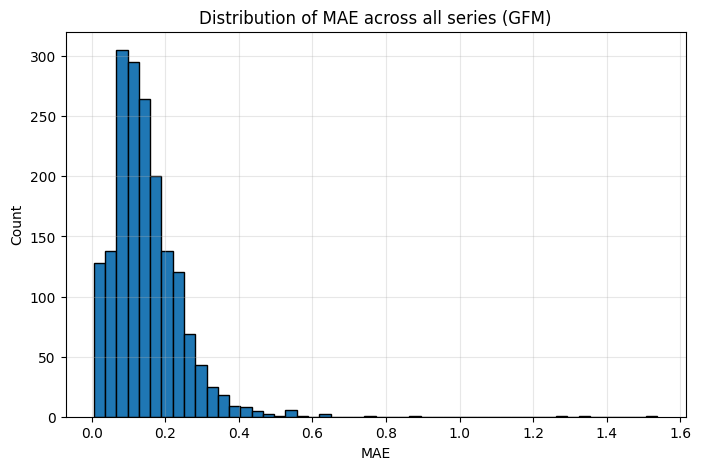

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(gfm_metrics['MAE'], bins=50, edgecolor='black')
plt.title('Distribution of MAE across all series (GFM)')
plt.xlabel('MAE')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

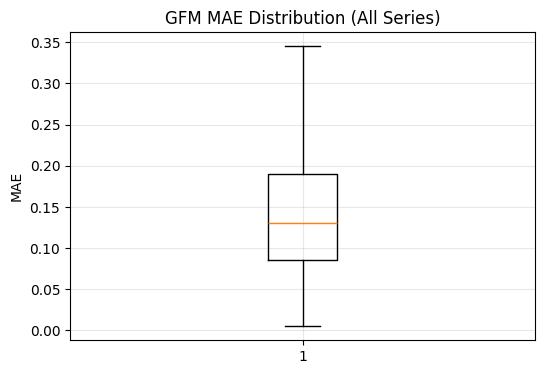

In [23]:
plt.figure(figsize=(6, 4))
plt.boxplot(gfm_metrics['MAE'], vert=True, showfliers=False)
plt.ylabel('MAE')
plt.title('GFM MAE Distribution (All Series)')
plt.grid(alpha=0.3)
plt.show()

In [24]:
gfm_metrics.sort_values('MAE', ascending=False).head(20)

,unique_id,MAE,store_nbr,family
1530,52_GROCERY I,1.538639,52,GROCERY I
1548,52_PRODUCE,1.333078,52,PRODUCE
1521,52_BEVERAGES,1.273891,52,BEVERAGES
1528,52_EGGS,0.894147,52,EGGS
1483,50_SCHOOL AND OFFICE SUPPLIES,0.771624,50,SCHOOL AND OFFICE SUPPLIES
1384,48_SCHOOL AND OFFICE SUPPLIES,0.622093,48,SCHOOL AND OFFICE SUPPLIES
1547,52_PREPARED FOODS,0.620054,52,PREPARED FOODS
1536,52_HOME CARE,0.581929,52,HOME CARE
310,19_GROCERY II,0.549348,19,GROCERY II
1527,52_DELI,0.546072,52,DELI


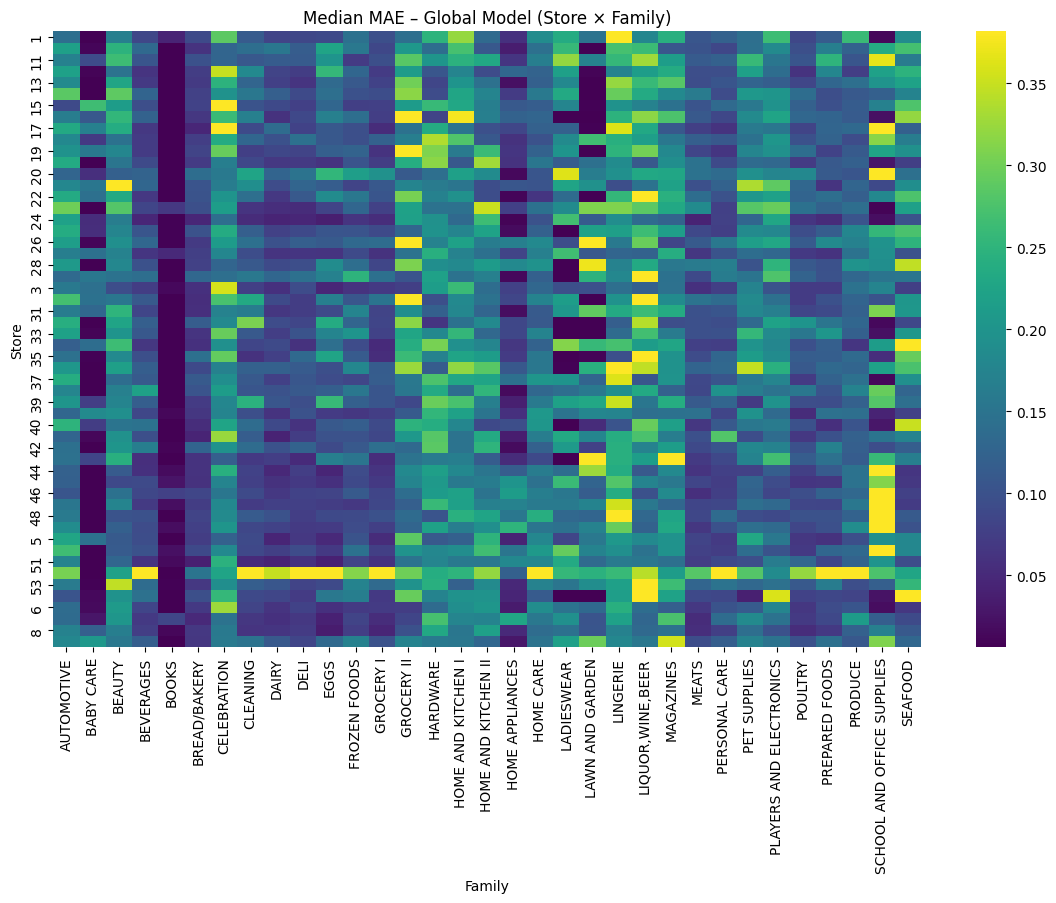

In [27]:
pivot = gfm_metrics.pivot_table(
    index='store_nbr',
    columns='family',
    values='MAE',
    aggfunc='median'
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot,
    cmap='viridis',
    robust=True
)
plt.title('Median MAE – Global Model (Store × Family)')
plt.xlabel('Family')
plt.ylabel('Store')
plt.show()

### Look at MASE

In [32]:
def mase_per_series(y_true, y_pred, y_train, seasonality=7):
    mae = mean_absolute_error(y_true, y_pred)
    scale = np.mean(np.abs(y_train[seasonality:] - y_train[:-seasonality]))
    return mae / scale

def safe_mase(y_true, y_pred, y_train, seasonality=7, eps=1e-8):
    mae = mean_absolute_error(y_true, y_pred)
    scale = np.mean(np.abs(y_train[seasonality:] - y_train[:-seasonality]))
    
    if scale < eps:
        return np.nan  # undefined MASE
    
    return mae / scale

mase_df = (
    test_df
    .groupby('unique_id')
    .apply(lambda x: safe_mase(
        y_true=x['y'].values,
        y_pred=x['y_pred'].values,
        y_train=train_df.loc[train_df['unique_id'] == x.name, 'y'].values,
        seasonality=7
    ))
    .reset_index(name='MASE')
)

/var/folders/hl/hqtbxwl95mj2hclnn1hfsc3m0000gn/T/ipykernel_41918/2395244680.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: safe_mase(


In [33]:
mase_df['MASE'].dropna().describe()

count    1729.000000
mean        0.621390
std         1.579969
min         0.032249
25%         0.307961
50%         0.389816
75%         0.522676
max        27.193214
Name: MASE, dtype: float64

In [34]:
total = len(mase_df)
invalid = mase_df['MASE'].isna().sum()

print(f"Excluded {invalid}/{total} series ({invalid/total:.1%}) due to zero naive scale")

Excluded 53/1782 series (3.0%) due to zero naive scale


In [35]:
print((mase_df['MASE'] < 1).mean(),mase_df.shape[0])

0.9175084175084175 1782


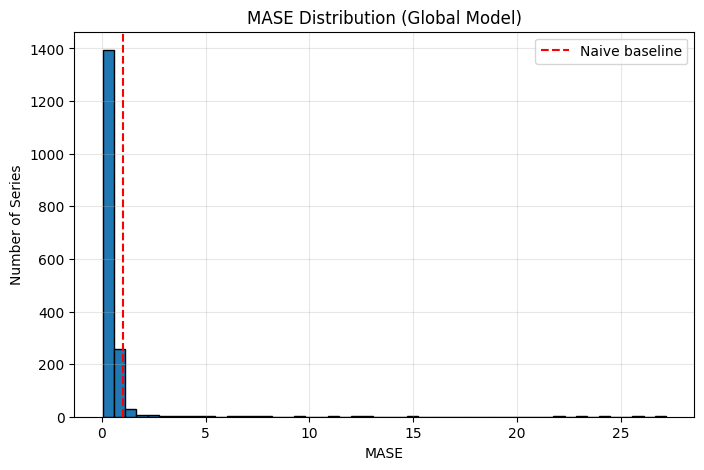

In [36]:
plt.figure(figsize=(8,5))
plt.hist(mase_df['MASE'].dropna(), bins=50, edgecolor='black')
plt.axvline(1, color='red', linestyle='--', label='Naive baseline')
plt.title('MASE Distribution (Global Model)')
plt.xlabel('MASE')
plt.ylabel('Number of Series')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [37]:
mase_df.sort_values('MASE', ascending=False).head(20)

,unique_id,MASE
1420,4_BABY CARE,27.193214
1530,52_GROCERY I,25.761935
1548,52_PRODUCE,24.208967
1528,52_EGGS,22.859946
1521,52_BEVERAGES,22.124265
1547,52_PREPARED FOODS,15.074582
1536,52_HOME CARE,12.700807
1527,52_DELI,12.152377
1543,52_PERSONAL CARE,10.997209
1525,52_CLEANING,9.440963
